# Topic model of ACL privacy full docs

In [1]:
# general imports
import warnings
import nltk
import pandas as pd
import numpy as np
import scipy as sp
from time import time, sleep
import json
import requests
import random
import os
import matplotlib.pyplot as plt
import re
from sklearn.externals import joblib
# Clean and lemmatize text
from nltk.corpus import stopwords
from gensim.utils import smart_open, simple_preprocess
from gensim.test.utils import datapath
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

import html5lib
import re
from bs4 import BeautifulSoup
import requests
from pprint import pprint
from pickle import dump,load
# Gensim
from gensim import similarities
import gensim
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.summarization.summarizer import summarize
from pprint import pprint

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning)

random.seed(0)
# %matplotlib inline

In [37]:
def compute_coherence_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            random_state=0,
            num_topics=num_topics,
            id2word=dictionary,
#             minimum_probability=0.3, 
            alpha = 'auto', 
            eta = 'auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [83]:
def format_topics_sentences(ldamodel, #optimal_model
                            corpus,#corpus
                            texts): #split_data_words
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series(
                        [int(topic_num),
                         round(prop_topic, 4), topic_keywords]),
                    ignore_index=True)
            else:
                break
    sent_topics_df.columns = [
        'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'
    ]

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)




# For new documents, extract the keywords
def get_topics_4_new_docs(model, topics,  prob = .3):
    topics.sort(key=lambda x: x[1], reverse = True) #This is in-place
    topic_keywords = [[topic[0], model.show_topic(topic[0])] for topic in topics if topic[1] > prob]
    return topic_keywords


# Display topics as a dataframe
def display_topics(feature_names, no_top_words, topic_words):
    word_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        #         print(topic_idx)
        #         print ([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        word_dict['Topic ' + str(topic_idx)] = [
            feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]
        ]
    return pd.DataFrame(
        word_dict
    )  #, columns=['Topic ' + str(k) for k in range(len(model.components_))])


# For new documents, extract the keywords
def get_similar_docs_4_new_docs(similarities_val, similarity_threshold):
    similarities_val.sort(key=lambda x: x[1], reverse = True) #This is in-place
#     print(similarities_val)
    similarities_val_thresh = [val[0] for val in similarities_val if val[1] > similarity_threshold]
    return similarities_val_thresh


In [7]:
# Load data
df = load(
    open("/Users/dbm/Documents/Insight S19/data/acl_privacy_policy_full_docs.pkl",
         "rb"))
data_words = load(
    open(
        "/Users/dbm/Documents/Insight S19/data/acl_privacy_policy_full_doc_words.pkl",
        "rb"))
print(df.shape, len(data_words))

(1010, 3) 1010


In [15]:
# Split data into words to create a BOW model
split_data_words = [content.split() for content in data_words]

## Train test split

In [16]:
# Split data into training and test sets
train_prop = 0.8
num_train = int(len(data_words)*train_prop)
train_words = split_data_words[:num_train]
test_words = split_data_words[num_train:]
train_df = df.iloc[:num_train,:]
test_df = df.iloc[num_train:,:]
print(f'Num documents in train set: {len(train_words)} \nNum documents in test set: {len(test_words)}')
print(f'Num documents in train set: {train_df.shape} \nNum documents in test set: {test_df.shape}')

Num documents in train set: 808 
Num documents in test set: 202
Num documents in train set: (808, 3) 
Num documents in test set: (202, 3)


In [17]:
train_df.head()

,file,text,type
0,/Users/dbm/Downloads/corpus/www_google_co_nz.xml,"When you share information with us, for exampl...",pp
1,/Users/dbm/Downloads/corpus/ibnlive_in.xml,Web18 recognizes the importance of protecting...,pp
2,/Users/dbm/Downloads/corpus/www_gocomics.xml,The privacy policy below details the measures ...,pp
3,/Users/dbm/Downloads/corpus/www_petsmart.xml,"By using this Site, you agree to be bound by o...",pp
4,/Users/dbm/Downloads/corpus/www_duolingo.xml,"By using, accessing or participating in the S...",pp


## Create BOW

In [18]:
%%time
# Create corpora for topic modeling
# Create dictionary train
id2word = corpora.Dictionary(train_words)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in train_words]

# Save corpora and dictionary
dump(corpus, open('acl_policy_corpus_train_fulldoc.pkl', 'wb'))
id2word.save('acl_policy_dictionary_train_fulldoc.gensim')

CPU times: user 985 ms, sys: 22.3 ms, total: 1.01 s
Wall time: 1.01 s


In [19]:
%%time
# Create dictionary test
id2word_test = corpora.Dictionary(test_words)

# Term Document Frequency
corpus_test = [id2word.doc2bow(text) for text in test_words]

# Save corpora and dictionary
dump(corpus_test, open('acl_policy_corpus_test_fulldoc.pkl', 'wb'))
id2word_test.save('acl_policy_dictionary_test_fulldoc.gensim')

CPU times: user 269 ms, sys: 8.55 ms, total: 278 ms
Wall time: 277 ms


In [ ]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## LDA model

In [38]:
%%time
# Determine optimum number of topics
# Can take a long time to run
model_list, coherence_values = compute_coherence_lda(
    dictionary=id2word, corpus=corpus, texts=train_words, start=2, limit=20, step=1)

CPU times: user 3min 57s, sys: 3.55 s, total: 4min
Wall time: 2min 41s


Max coherence: 0.28820981161233966, Num Topics at max coherence: 4


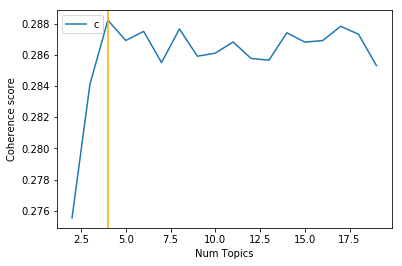

In [39]:
# Show graph
limit = 20
start = 2
step = 1
#  Find the index of the max value
max_idx = coherence_values.index(max(coherence_values))
# Sanity check
# coherence_values[19]
x = range(start, limit, step)
print(f'Max coherence: {max(coherence_values)}, Num Topics at max coherence: {x[max_idx]}')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=x[max_idx], color = 'orange')
plt.show()

In [23]:
# Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [40]:
# Select the model and print the topics
optimal_model = model_list[max_idx]
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [41]:
%%time
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=train_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.796049323877958

Coherence Score:  0.28820981161233966
CPU times: user 8.92 s, sys: 172 ms, total: 9.1 s
Wall time: 7.18 s


In [42]:
# Save model to disk.
temp_file = datapath("./optimal_LDA_model_acl_train_4top_fulldoc")
optimal_model.save(temp_file)

In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, R = 20, sort_topics = True)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.005634 -0.001616       1        1  36.195114
0      0.002038 -0.005342       2        1  31.583754
2     -0.001808  0.004967       3        1  19.291645
1      0.005405  0.001991       4        1  12.929485, topic_info=     Category          Freq           Term         Total  loglift  logprob
372   Default  16734.000000           site  16734.000000  20.0000  20.0000
196   Default  46861.000000    information  46861.000000  19.0000  19.0000
262   Default  10652.000000          party  10652.000000  18.0000  18.0000
101   Default   6689.000000           data   6689.000000  17.0000  17.0000
359   Default  11035.000000        service  11035.000000  16.0000  16.0000
85    Default   3754.000000        content   3754.000000  15.0000  15.0000
91    Default   8068.000000          cooky   8068.000000  14.0000  14.0000
18    Default   3313.000000    advertising   3313.000000  13.0000  13.0000
650   Default  10007.000000          third  10007.000000  12.0000  12.0000
429   Default   9599.000000        website   9599.000000  11.0000  11.0000
11    Default   6926.000000        address   6926.000000  10.0000  10.0000
235   Default   2225.000000         mobile   2225.000000   9.0000   9.0000
24    Default   5385.000000           also   5385.000000   8.0000   8.0000
417   Default   8075.000000           user   8075.000000   7.0000   7.0000
296   Default   7231.000000        provide   7231.000000   6.0000   6.0000
269   Default  12489.000000       personal  12489.000000   5.0000   5.0000
4     Default   4292.000000        account   4292.000000   4.0000   4.0000
2     Default   4619.000000         access   4619.000000   3.0000   3.0000
62    Default   3183.000000         change   3183.000000   2.0000   2.0000
68    Default   6467.000000        collect   6467.000000   1.0000   1.0000
8199   Topic1      1.009878        unwomen      1.190717   0.8515 -12.6544
8198   Topic1      1.006401       ixrkymya      1.194762   0.8447 -12.6578
9477   Topic1      8.210311       starfall     10.365082   0.7832 -10.5588
8170   Topic1     20.505329      economist     27.513258   0.7223  -9.6435
3752   Topic1      0.924317          octet      1.258905   0.7073 -12.7429
8762   Topic1      1.731716      proposing      2.362665   0.7056 -12.1151
7469   Topic1      1.744189          tigta      2.410834   0.6926 -12.1079
5648   Topic1      8.254957        boulder     11.624565   0.6739 -10.5534
4604   Topic1      1.706145     racecourse      2.429258   0.6629 -12.1300
6557   Topic1      8.881543       graduate     12.698310   0.6588 -10.4803
...       ...           ...            ...           ...      ...      ...
8623   Topic4      9.977221      jerusalem     28.481468   0.9967  -9.3345
7179   Topic4      4.659625          typed     12.612061   1.0499 -10.0959
9662   Topic4     14.377125          mappy     44.920006   0.9064  -8.9692
235    Topic4    466.424347         mobile   2225.951904   0.4828  -5.4897
85     Topic4    733.221008        content   3754.310791   0.4124  -5.0374
2263   Topic4     31.222702          reply    109.431274   0.7915  -8.1937
18     Topic4    604.099487    advertising   3313.914551   0.3435  -5.2311
262    Topic4   1660.409790          party  10652.466797   0.1869  -4.2200
1601   Topic4    172.213440           well    799.912781   0.5099  -6.4861
372    Topic4   2336.035645           site  16734.363281   0.0767  -3.8786
494    Topic4    449.811432       customer   2625.359375   0.2815  -5.5260
101    Topic4    985.140747           data   6689.479004   0.1302  -4.7420
91     Topic4   1123.842773          cooky   8068.588379   0.0744  -4.6103
24     Topic4    800.349487           also   5385.271484   0.1393  -4.9498
316    Topic4    281.646576      regarding   1576.200806   0.3235  -5.9942
429    Topic4   1228.664307        website   9599.561523  -0.0101  -4.5211
359    Topic4   1362.849854      

In [44]:
# Save lda vis
pyLDAvis.save_html(vis, 'acl_optimal_lda_4top_fulldoc.html')

In [45]:
# Find the dominant topic for each document
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=train_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(1)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.3765,"information, personal, site, website, service,...","[share, information, example, creating, accoun..."


In [46]:
optimal_model.show_topics(formatted=True, num_words=10)

[(0,
  '0.049*"information" + 0.019*"site" + 0.016*"third" + 0.016*"service" + 0.013*"party" + 0.012*"personal" + 0.011*"website" + 0.010*"user" + 0.010*"cooky" + 0.009*"provide"'),
 (1,
  '0.039*"information" + 0.021*"site" + 0.015*"party" + 0.012*"service" + 0.011*"website" + 0.010*"cooky" + 0.010*"personal" + 0.009*"third" + 0.009*"data" + 0.009*"user"'),
 (2,
  '0.051*"information" + 0.026*"site" + 0.014*"personal" + 0.010*"party" + 0.010*"service" + 0.009*"third" + 0.009*"user" + 0.008*"address" + 0.008*"data" + 0.008*"cooky"'),
 (3,
  '0.064*"information" + 0.018*"personal" + 0.015*"site" + 0.013*"website" + 0.012*"service" + 0.012*"party" + 0.009*"cooky" + 0.009*"third" + 0.009*"user" + 0.008*"data"')]

In [47]:
# Merge topic info with main df
train_df_with_topic = pd.concat([train_df, df_dominant_topic], axis = 1)
print(train_df_with_topic.isna().sum())
train_df_with_topic.head(2)

file                  0
text                  0
type                  0
Document_No           0
Dominant_Topic        0
Topic_Perc_Contrib    0
Keywords              0
Text                  0
dtype: int64


,file,text,type,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,/Users/dbm/Downloads/corpus/www_google_co_nz.xml,"When you share information with us, for exampl...",pp,0,3.0,0.3765,"information, personal, site, website, service,...","[share, information, example, creating, accoun..."
1,/Users/dbm/Downloads/corpus/ibnlive_in.xml,Web18 recognizes the importance of protecting...,pp,1,3.0,0.6369,"information, personal, site, website, service,...","[recognizes, importance, protecting, informati..."


## Apply topic model to new documents

In [48]:
%%time
# get topic probability distribution for new documents and keywords
new_doc_topic =[]
new_doc_topic_kwords =[]
for i,doc in enumerate(test_words):
    new_doc_bow = id2word.doc2bow(doc)
    try:
        vector = optimal_model[new_doc_bow]#optimal_model.get_document_topics(new_doc_bow) <-- does the same thing
        new_doc_topic.append(vector) 
        new_doc_topic_kwords.append(get_topics_4_new_docs(model = optimal_model, topics= vector, prob = 0.3))        

    except:
        vector = ''
        new_doc_topic.append([i,''])
        new_doc_topic_kwords.append([i, ''])

CPU times: user 1.51 s, sys: 15 ms, total: 1.52 s
Wall time: 383 ms


In [49]:
# Find the dominant topic for each document
df_topic_sents_keywords_test = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus_test, texts=test_words)

# Format
df_dominant_topic_test = df_topic_sents_keywords_test.reset_index()
df_dominant_topic_test.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [50]:
# Merge in test_df with topic info
test_df = test_df.reset_index(drop=True)
test_df_with_topic = pd.concat([test_df, df_dominant_topic_test], axis = 1)
print(test_df_with_topic.isna().sum())

file                  0
text                  0
type                  0
Document_No           0
Dominant_Topic        0
Topic_Perc_Contrib    0
Keywords              0
Text                  0
dtype: int64


In [51]:
test_df_with_topic.head()

,file,text,type,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,/Users/dbm/Downloads/corpus/www_dhl.xml,(hereinafter called 'DHL') is pleased that you...,pp,0,3.0,0.7007,"information, personal, site, website, service,...","[hereinafter, called, pleased, visited, websit..."
1,/Users/dbm/Downloads/corpus/www_yale_edu.xml,Any information you voluntarily provide to us ...,pp,1,3.0,0.5982,"information, personal, site, website, service,...","[information, voluntarily, provide, yale, univ..."
2,/Users/dbm/Downloads/corpus/pages_ebay_com_au.xml,This Privacy Policy describes how eBay Intern...,pp,2,3.0,0.6425,"information, personal, site, website, service,...","[describes, ebay, international, registered, o..."
3,/Users/dbm/Downloads/corpus/info_sciencedirect...,"No. 33156677, BTW No. NL005033019B01 (""Elsevie...",pp,3,3.0,0.4129,"information, personal, site, website, service,...","[committed, maintaining, confidence, trust, re..."
4,/Users/dbm/Downloads/corpus/about_abc_net_au.xml,Our goal is to provide you and your family wit...,pp,4,3.0,0.5556,"information, personal, site, website, service,...","[goal, provide, family, medium, experience, in..."


## Update topic model

In [52]:
# Update model with the test corpus
optimal_model.update(corpus_test)

In [57]:
%%time
# Compute Perplexity
# Expect perplexity to decrease and coherence to increase
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=test_words, dictionary=id2word_test, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.8001539683060495

Coherence Score:  0.40871700452187754
CPU times: user 8.52 s, sys: 139 ms, total: 8.66 s
Wall time: 3.09 s


In [58]:
# Save model to disk.
temp_file2 = datapath("./optimal_LDA_model_acl_train_4top_fulldoc_updated")
optimal_model.save(temp_file2)

## Update model with single document

In [110]:
new_doc = test_words[0]
new_doc_bow = id2word.doc2bow(new_doc)
new_doc_top_prob_dist = optimal_model[new_doc_bow] 
new_doc_top_prob_dist_df = pd.DataFrame([{'topic': i[0], 'prob':i[1]} for i in new_doc_top_prob_dist])
new_doc_top_kwords = get_topics_4_new_docs(model = optimal_model, topics=new_doc_top_prob_dist, prob = .3)
new_doc_top_kwords
# optimal_model.update(new_doc_bow)

[[3,
  [('information', 0.0640159),
   ('personal', 0.019337073),
   ('website', 0.016995635),
   ('site', 0.013105628),
   ('service', 0.011147188),
   ('party', 0.0110497875),
   ('data', 0.0100991),
   ('cooky', 0.010093257),
   ('third', 0.008876132),
   ('user', 0.008633475)]]]

In [109]:
new_doc_top_prob_dist

[(3, 0.94275415), (1, 0.040611517), (2, 0.012470194)]

In [60]:
# Get similarities among topics in the corpus
lda_index = similarities.MatrixSimilarity(optimal_model[corpus])

In [61]:
# Find documents similar to new document
# Let's perform some queries
similarities_1 = lda_index[optimal_model[new_doc_bow]]

# print(similarities_1.shape)
# Sort the similarities
similarities_1 = sorted(enumerate(similarities_1), key=lambda item: -item[1])
 
# Top most similar documents:
# print(similarities_1[:10])
 
# Let's see what's the most similar document
document_id, similarity_1 = similarities_1[0]

similar_docs = get_similar_docs_4_new_docs(similarities_val = similarities_1, similarity_threshold  = 0.99)
print(similar_docs)
# Print a similar document
train_df_with_topic['text'][similar_docs[0]]

[475, 176, 754, 294, 412, 108, 505, 7, 564, 40, 644, 317, 693, 724, 702, 152, 591, 262, 337, 223, 92, 213, 122, 373, 600, 378, 5, 48, 73, 89, 249, 389, 547, 575, 647, 461, 313, 593, 326, 75, 261, 6, 231, 155, 685, 250, 393, 515, 768, 408, 254, 651, 579, 133, 166, 306, 52, 193, 797, 45, 616, 101, 472, 244, 96, 77, 196, 211, 462, 691, 518, 728, 68, 218, 136, 507, 124, 783, 406, 661, 746, 154, 405, 388, 760, 608, 139, 446, 717, 753, 607, 454, 119, 189, 325, 285, 295, 284, 741, 304, 586, 72, 581, 46, 328, 733, 100, 190]


"Files with private key, personal logins, passwords or other secret and significant data are subject to steal because such data provide access to different services and resources. The whole complex of measures and special hard and software devices (firewalls, proxy servers) are used in WebMoney Transfer to prevent unauthorized access. If you wish to prevent your computer from unauthorized access, follow our pieces of advice. In this case, you can make payments worth thousands of dollars from your computer without any fear to lose them. To prevent your computer from unauthorized access you just need to follow these recommendations:\n\nIt is advisable to install Windows 7 on your computer. Security of Linux (Unix) requires HIGHLY qualified specialists and therefore it can hardly be advisable for use. Regularly update Service Park and Hot-fix at windowsupdate. Maximally approximate OS security to the S2 standard or ITSEC (refer to\nhttp://www.microsoft.com/security/default.aspx\nhttp://ww

## Summarize by topic

In [64]:
# Get the top n documents for each topic
df_topic_gr = train_df_with_topic.groupby('Dominant_Topic')
summary_stories = {}
return_prop = 0.05
for group, _df in df_topic_gr:  
#     display(' '.join(_df['story']))
    for doc in _df['text']:
        tmp = sent_tokenize(doc)
        tmp_clean = [i.split('\n\n') for i in tmp]
        text_pp = ' '.join(sum(tmp_clean,[]))
        try:
            summary = summarize(text_pp, ratio = return_prop)   
        except:
            summary = text_pp
#         summary_stories.append({'Dominant Topic':group, 'Summary':summary})
        summary_stories = {'Dominant Topic':group, 'Summary':summary}

# df_with_topic = dfs.join(df.set_index('Document_No'), on='Document_No')
# df_with_topic.head(5)

In [ ]:
summary_stories[3]

In [ ]:
tmp = df_topic_gr.get_group(1)

In [ ]:
tmp = sent_tokenize(test_df_with_topic['text'][0])
tmp_clean = [i.split('\n\n') for i in tmp]
text_pp = ' '.join(sum(tmp_clean,[]))
summarize(text_pp, ratio  = 0.05)